In [1]:
from vcdvcd import VCDVCD
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

The verilog used to generate this VCD file looks something like this:

```verilog
wire [7:0] dump = {
    clock, reset, HSync, VSync, blank,
    red[7], green[7], blue[7]
};

initial begin
    $dumpvars(0, dump);
    $dumpfile("renderer_tb.vcd");
    ...
    repeat(900000) @(posedge clock);
    ...
    $finish
end
```

VGA timings reference:
- http://tinyvga.com/vga-timing/640x480@60Hz
- https://projectf.io/posts/video-timings-vga-720p-1080p/

In [2]:
# Load the file
vcd1 = VCDVCD("vga_frame.vcd")
CLOCK_RATIO = 2
print(vcd1.signals)

['vga_tb.dump[7:0]']


In [3]:
# Preview the data
vcd1["vga_tb.dump[7:0]"].tv[:10]

[(0, '01xxxxxx'),
 (5, '11xxxxxx'),
 (10, '01xxxxxx'),
 (15, '11xxxxxx'),
 (15, '11001xxx'),
 (15, '11001000'),
 (20, '01001000'),
 (25, '11001000'),
 (30, '00001000'),
 (35, '10001000')]

In [4]:
sig = []
prev_ind = -1

for ind, x in vcd1["vga_tb.dump[7:0]"].tv:
    # Remove indeterminate and reset states
    if "x" in x or "z" in x or x[1] == "1":
        continue
        
    # Take only rising-edge of clock
    if x[0] != "1":
        continue
    
    # Pull out the values we care about
    parsed = (
        int(x[2]),
        int(x[3]),
        int(x[4]),
        int(x[5]),
        int(x[6]),
        int(x[7])
    )
    
    # For timesteps where multiple transitions happen,
    # take the last one
    if ind == prev_ind:
        sig[-1] = parsed
    else:
        sig.append(parsed)
        prev_ind = ind


In [5]:
# Split up the "rows" in the stream, by looking at when HSync pin is set
cur_row = []
rows = []
for hs, vs, blank, r, g, b in sig:
    if not hs:
        if len(cur_row):
            rows.append(cur_row)
            cur_row = []
    else:
        cur_row.append((vs, blank, r, g, b))
    

In [6]:
# Split up the "frames" amongst the rows by looking at the VSync pin
init = True
frames = []
frame = None
vsctr = 0
for row in rows:
    if not row[0][0]:
        init = False
        assert row[0][1]
        if frame and len(frame):
            frames.append(frame)
        frame = None
        assert vsctr < 2
        vsctr += 1
        if vsctr == 2:
            frame = []
    else:
        vsctr = 0
        assert frame is not None or init
        if not init:
            frame.append(row)

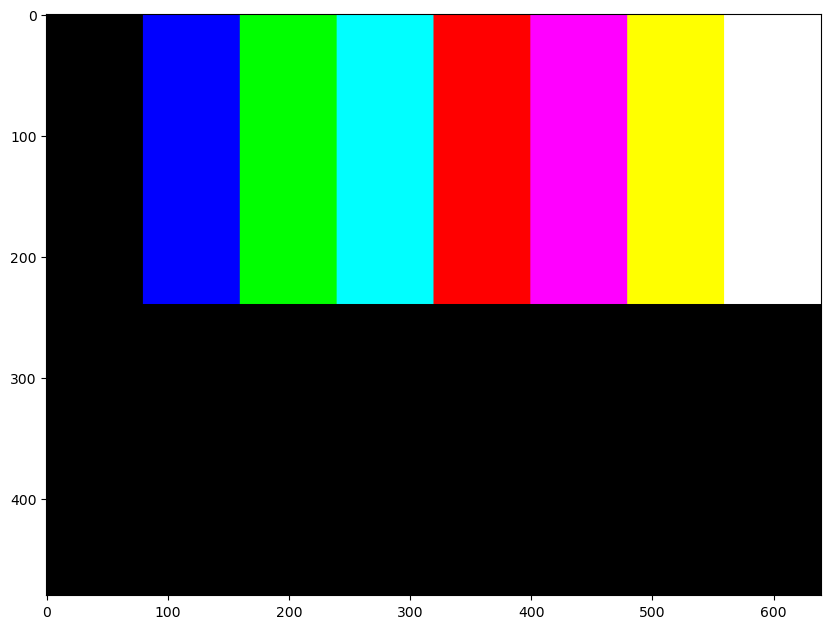

In [7]:
frame = frames[0]

# Front porch and back porch (blank rows in frame)
bp = frame[0:29]
rows = frame[29:509]
fp = frame[509:519]

# Image dims are fixed because of the specific VGA variant we are using
img = np.zeros((480, 640, 3), dtype=np.uint8)

# Go thru rows
for i, row in enumerate(rows):
    
    # Front porch and back porch (blank cols in row)
    row_bp = row[0:48*CLOCK_RATIO]
    dat = row[48*CLOCK_RATIO:688*CLOCK_RATIO]
    row_fp = row[688*CLOCK_RATIO:704*CLOCK_RATIO]

    # Pull the columns, set the pixels in the image
    for j, col in enumerate(dat):
        vs, blank, r, g, b = col
        
        # Since the outputs are one-bit, we scale by 255
        img[i, j // CLOCK_RATIO, :] = (r*255, g*255, b*255)

plt.figure(figsize=(10, 10))
plt.imshow(img)